# PCA using library implementation
Here, we use Principal Component Analysis (or dimensionality reduction) for feature selection. 

In [1]:
# Importing required libraries
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

## Dataset Operations

In [2]:
from sklearn.preprocessing import OneHotEncoder
df = pd.read_csv("cleaned_shifted_data.csv")
    
oe = OneHotEncoder(sparse=False)
encoded = oe.fit_transform(pd.DataFrame(df['Station']))

In [3]:
oe.get_feature_names()

array(['x0_IITG ', 'x0_LGBI Airport ', 'x0_Pan Bazaar ',
       'x0_Railway Colony '], dtype=object)

In [4]:

one_hot_df = pd.DataFrame(encoded, columns=oe.get_feature_names())
df = pd.concat([df, one_hot_df], axis=1)

df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['year'] = df['Timestamp'].dt.year
df['month'] = df['Timestamp'].dt.month
df['dayofweek'] = df['Timestamp'].dt.day_of_week

drop_cols = [0,1,2,12,14,16]
drop_cols = df.columns[drop_cols]
df.drop(drop_cols,axis=1,inplace=True)

X = df.drop('AQI_calculated_shifted',axis = 1)
y = df['AQI_calculated_shifted']

In [5]:
X.head()

,PM2.5 (µg/m³),PM10 (µg/m³),NO (µg/m³),NO2 (µg/m³),NOx (ppb),NH3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Ozone (µg/m³),AQI_calculated,x0_IITG,x0_LGBI Airport,x0_Pan Bazaar,x0_Railway Colony,year,month,dayofweek
0,46.00,80.00,1.29,9.16,12.02,27.19,13.56,0.40,15.80,67.0,0.0,0.0,0.0,1.0,2019,2,6
1,46.00,80.00,1.74,8.93,12.48,30.29,13.71,0.41,15.52,68.0,0.0,0.0,0.0,1.0,2019,2,6
2,45.62,79.92,1.87,8.56,12.17,28.20,13.88,0.41,15.33,68.0,0.0,0.0,0.0,1.0,2019,2,6
3,41.00,72.92,1.83,8.72,12.37,26.69,13.77,0.40,15.30,68.0,0.0,0.0,0.0,1.0,2019,2,6
4,41.00,79.00,1.69,7.91,11.30,26.83,13.87,0.41,15.49,68.0,0.0,0.0,0.0,1.0,2019,2,6


In [6]:
print(X.shape, y.shape)

(174762, 17) (174762,)


## PCA functions

In [7]:
# Carry out PCA to reduce the number of features to 7 components
pca = PCA(n_components = 7) 
X_pca = pca.fit_transform(X)
X_pca

array([[-72.60390678, -35.79727503,   0.32495976, ...,  -5.9953184 ,
         -7.93759767,  -8.6547094 ],
       [-71.87008966, -35.06667508,   0.92447327, ...,  -6.45623666,
         -8.25979123,  -8.97627104],
       [-72.12414628, -34.97122613,   0.58316818, ...,  -6.62310091,
         -7.80292951,  -8.11479047],
       ...,
       [ 70.17149491,  82.41970169, -18.56308388, ...,  35.28988071,
         25.2838762 ,   6.43343402],
       [ 65.5445721 ,  74.06044015, -13.70693138, ...,  15.32303614,
        -16.30424551,   4.67622437],
       [138.4618077 ,  -5.56779413, -40.06136968, ...,   4.83313308,
        -17.80952622,   4.93745203]])

In [8]:
print(X_pca.shape)

(174762, 7)


## Explained Variance

In [9]:
# Calculate the cumulative variance ratio for number of features= 1->7
explained_var_ratio = pca.explained_variance_ratio_  
cumulative_var_ratio = np.cumsum(explained_var_ratio)

In [10]:
# Check explained variance on using 7 features
print(f"Explained variance: {cumulative_var_ratio[6]:.4f}")

Explained variance: 0.9967


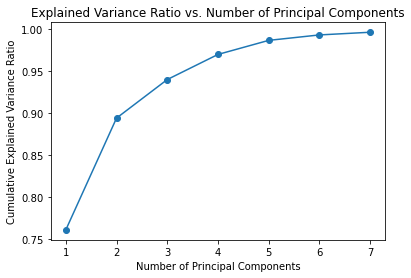

In [11]:
# Plot the explained variance ratio
plt.plot(range(1, len(cumulative_var_ratio) + 1), cumulative_var_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Principal Components')
plt.show()

## Apply Lasso, Ridge on PCA dataset

In [12]:
print(X_pca.shape, y.shape)

(174762, 7) (174762,)


In [13]:
# Splitting dataset into train and test set 
X_train, X_test, Y_train, Y_test = train_test_split( X_pca, y, test_size = 1 / 3, random_state = 0 )
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(116508, 7)
(58254, 7)
(116508,)
(58254,)


### Lasso

In [18]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
parameters = {'alpha': 0.5,
              'tol': 0.1
              }
model = Lasso(**parameters)

model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
score = r2_score(Y_test, Y_pred)
print("R2 {}".format(score))
mse = mean_squared_error(Y_test, Y_pred)
print("MSE", mse)

R2 0.39967918164664584
MSE 6714.345064417074


In [15]:
# Calculate the custom error metric
from error_define import *
Y_pred1 = Y_pred.reshape(-1, 1)
Y_test1 = Y_test.values.reshape(-1, 1)
downside_square_error(Y_pred1,Y_test1)

array([4245.00715961])

### Ridge

In [16]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
parameters = {'alpha': 0.5
              }
model = Ridge(**parameters)

model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
score = r2_score(Y_test, Y_pred)
print("R2 {}".format(score))
mse = mean_squared_error(Y_test, Y_pred)
print("MSE", mse)

R2 0.39968694912186353
MSE 6714.258188354648


In [17]:
# Calculate the custom error metric
from error_define import *
Y_pred1 = Y_pred.reshape(-1, 1)
Y_test1 = Y_test.values.reshape(-1, 1)
downside_square_error(Y_pred1,Y_test1)

array([4244.84184419])